### Import Modules/Packages

In [1]:
import sklearn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Import Data (Train and Test)

In [2]:
df_house_train = pd.read_csv(
    r"train.csv",
    low_memory=False,
)
# df_house_test = pd.read_csv(
#     r"test.csv",
#     low_memory=False,
# )

# drop columns with all NaN values
df_house_train.dropna(axis=1, how="all")
# df_house_test.dropna(axis=1, how="all")

# limit to only residential properties
residential = ["FV", "RH", "RL", "RP", "RM"]
df_house_train = df_house_train[df_house_train["MSZoning"].isin(residential)]
# df_house_test = df_house_test[df_house_test["MSZoning"].isin(residential)]
print("Train Data Shape: ", df_house_train.shape)
# print("Test Data Shape: ", df_house_test.shape)


Train Data Shape:  (1450, 81)


### Combine Train and Test Data Sets

In [3]:
# Combine Train and Test data sets
    # this allows for all added column/features to be available in both 
# Combined_df = pd.concat([df_house_train, df_house_test], ignore_index=True)


In [4]:
# Fill missing data with zero

def fill_missing_data(df: pd.DataFrame):
    for col_ in df.columns:
        if df[col_].dtype == "object":
            # fill 'NONE' for categorical features
            df[col_].fillna("NONE", inplace=True)
        else:
            # fill zero for numerical features
            df[col_].fillna(0, inplace=True)


fill_missing_data(df_house_train)


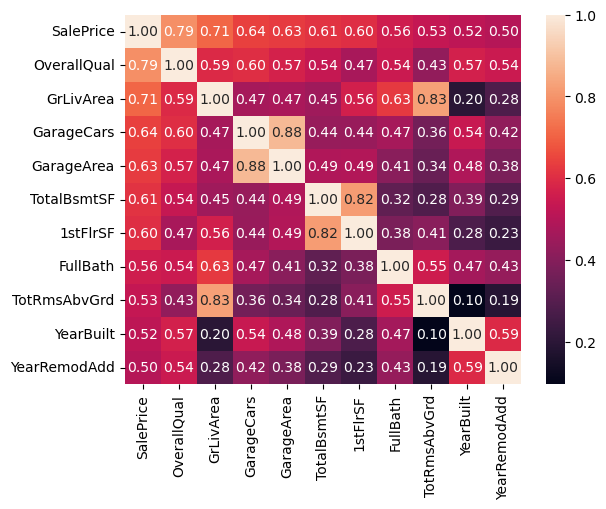

In [5]:
correlation = df_house_train.corr()
top_10_corr = correlation.nlargest(11, "SalePrice")["SalePrice"].index
cm = np.corrcoef(df_house_train[top_10_corr].values.T)
correlation_hm = sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=top_10_corr.values,
    xticklabels=top_10_corr.values,
)


#### Remove Outliers

In [6]:
# Combined_df = Combined_df[df_house_train.GrLivArea < 4400]
# Combined_df = Combined_df[Combined_df.TotalBsmtSF < 2500]


#### Building the Models

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler


In [8]:
# Define features to use in model 
Features = top_10_corr.copy().delete([0])


In [9]:
# Create copy of data set
train_df = df_house_train.copy()
# Filter to rows included in df_house_train set for train 
train_df = train_df[train_df.Id.isin(df_house_train.Id)]

# Set up Train and Validation Sets
    # test size = 20%
    # random state = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    train_df[Features], train_df["SalePrice"], test_size=0.2, random_state=42
)
_, X_valid_with_id, _, _ = train_test_split(
    train_df.drop("SalePrice", axis=1),
    train_df["SalePrice"],
    test_size=0.2,
    random_state=42,
)
# Create copy of comb_df
    # limit to only rows included in df_house_test for test 
test_df = df_house_train.copy()
# test_df = test_df[test_df.Id.isin(df_house_test.Id)]

X_test = test_df[Features]


In [10]:
# Removed to accommodate UI. When not using, this will increase performance

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)
# X_test = scaler.transform(X_test)


#### XGBoost Model

In [11]:
from xgboost import XGBRegressor

In [12]:
XGmodel = XGBRegressor(n_estimators=3000, learning_rate=0.005)

In [13]:
XGmodel.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [14]:
print(f"Train Accuracy : {XGmodel.score(X_train,y_train)}")
print(f"Validation Accuracy : {XGmodel.score(X_valid,y_valid)}")

Train Accuracy : 0.9897838709073911
Validation Accuracy : 0.8419648622066889


In [15]:
XGdata = test_df
XGdata["SalePrice"] = XGmodel.predict(X_test)
XGdata = XGdata[["Id", "SalePrice"]]
XGdata


,Id,SalePrice
0,1,198742.765625
1,2,168695.468750
2,3,218233.843750
3,4,144132.546875
4,5,255934.203125
...,...,...
1455,1456,177297.015625
1456,1457,209995.906250
1457,1458,267713.125000
1458,1459,138333.468750


In [17]:
# Used for UI
import pickle
# Save the XGmodel to a file
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(XGmodel, file)